## Problem Statement:
The last two decades have witnessed a significant change in how consumers purchase products and express their experience/opinions in reviews, posts, and content across platforms.

These online reviews are not only useful to reflect customers’ sentiment towards a product but also help businesses fix gaps and find potential opportunities which could further influence future purchases. 

The challenge here is to analyze and deep dive into the natural language text (reviews) and bucket them based on their topics of discussion. Furthermore, analyzing the overall sentiment will also help the business to make tangible decisions.

The data set provided to you has a mix of customer reviews for products across categories and retailers. We would like you to model on the data to bucket the future reviews in their respective topics (Note: A review can talk about multiple topics)

Overall polarity (positive/negative sentiment)

#### Train: 6136 rows x 14 columns
#### Test: 2631 rows x 14 columns 
 
- Topics (Components, Delivery and Customer Support, Design and Aesthetics, Dimensions, Features, Functionality, Installation, Material, Price, Quality and Usability)
- Polarity (Positive/Negative)

Check Problem Statement: [MachineHack](https://machinehack.com/hackathon/uhack_sentiments_20_decode_code_words/overview)

[MY Rank](https://machinehack.com/hackathon/uhack_sentiments_20_decode_code_words/leaderboard)

## Importing required Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\Vaibhav\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import re
import contractions
import swifter
from bs4 import BeautifulSoup

import nltk
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, precision_score, f1_score, roc_auc_score, log_loss

from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
train_df = pd.read_csv('train.csv')

In [6]:
test_df = pd.read_csv('test.csv')

In [7]:
train_df.head()

,Id,Review,Components,Delivery and Customer Support,Design and Aesthetics,Dimensions,Features,Functionality,Installation,Material,Price,Quality,Usability,Polarity
0,0,For some reason everybody complains and I'm co...,0,0,0,0,0,0,0,0,0,0,1,0
1,1,"I like everything about it, great choice of sp...",0,0,0,0,1,1,0,0,0,0,0,1
2,2,Excellent ceiling fan brace. Easy to install a...,0,0,0,0,0,0,1,0,0,1,0,1
3,3,Work great easy to use . No issues at all with...,0,0,0,0,0,1,0,0,0,0,1,1
4,4,I would recommend this product because it is p...,0,0,0,0,0,0,0,0,0,1,0,1


In [8]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,6136.0,3067.500000,1771.454958,0.0,1533.75,3067.5,4601.25,6135.0
Components,6136.0,0.044654,0.206561,0.0,0.00,0.0,0.00,1.0
Delivery and Customer Support,6136.0,0.029172,0.168302,0.0,0.00,0.0,0.00,1.0
Design and Aesthetics,6136.0,0.105932,0.307776,0.0,0.00,0.0,0.00,1.0
Dimensions,6136.0,0.113266,0.316943,0.0,0.00,0.0,0.00,1.0
Features,6136.0,0.051010,0.220037,0.0,0.00,0.0,0.00,1.0
Functionality,6136.0,0.413625,0.492523,0.0,0.00,0.0,1.00,1.0
Installation,6136.0,0.124185,0.329820,0.0,0.00,0.0,0.00,1.0
Material,6136.0,0.025261,0.156929,0.0,0.00,0.0,0.00,1.0
Price,6136.0,0.139179,0.346161,0.0,0.00,0.0,0.00,1.0


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6136 entries, 0 to 6135
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Id                             6136 non-null   int64 
 1   Review                         6136 non-null   object
 2   Components                     6136 non-null   int64 
 3   Delivery and Customer Support  6136 non-null   int64 
 4   Design and Aesthetics          6136 non-null   int64 
 5   Dimensions                     6136 non-null   int64 
 6   Features                       6136 non-null   int64 
 7   Functionality                  6136 non-null   int64 
 8   Installation                   6136 non-null   int64 
 9   Material                       6136 non-null   int64 
 10  Price                          6136 non-null   int64 
 11  Quality                        6136 non-null   int64 
 12  Usability                      6136 non-null   int64 
 13  Pol

In [10]:
train_df['Polarity'].value_counts()/len(train_df.index)*100

1    77.73794
0    22.26206
Name: Polarity, dtype: float64

In [11]:
train_df['Price'].value_counts()

0    5282
1     854
Name: Price, dtype: int64

In [12]:
train_df.nunique()

Id                               6136
Review                           6136
Components                          2
Delivery and Customer Support       2
Design and Aesthetics               2
Dimensions                          2
Features                            2
Functionality                       2
Installation                        2
Material                            2
Price                               2
Quality                             2
Usability                           2
Polarity                            2
dtype: int64


## 2.Preprocessing Review Text

We will perform the below preprocessing tasks:
- Convert everything to lowercase
- Remove HTML tags
- Remove URL from sentence
- Contraction mapping
- Eliminate punctuations and special characters
- Remove stopwords
- Remove short words

In [13]:
stopword_list = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", \
             "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", \
             'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',\
             'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', \
             'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', \
             'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about',
             'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', \
             'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', \
             'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', \
             'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', \
             'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", \
             'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', \
             "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't",
             'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't" \
            ]

In [14]:
def decontracted(sentance):
    '''
    Function to expand the shotened words
    '''
    expanded_words = []    
    for word in sentance.split():
      # using contractions.fix to expand the shotened words
      expanded_words.append(contractions.fix(word))   

    expanded_text = ' '.join(expanded_words)
    return expanded_text

In [14]:
wordnet_lemmatizer = WordNetLemmatizer()
def lemma_stopword(sentence):
    # tokenize into words
    sentence = word_tokenize(sentence)
#     sentence = TweetTokenizer(sentence)

    # remove stopwords
    sentence = [word.strip() for word in sentence if word not in stopword_list]    # remove stopwords
    # lemmatizer
    sentence = [wordnet_lemmatizer.lemmatize(word, pos='v') for word in sentence]
    sentence = " ".join(sentence)
    return sentence

In [15]:
def sentence_clean(sentence):
    '''
    Function to clean the text and remove all the unnecessary elements.
    '''
    sentence = sentence.lower()    # make the text lowercase
    sentence = decontracted(sentence)    # expand the shotened words   what've ---> what have
    sentence = lemma_stopword(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence)  # remove words with digits   
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)  # remove punctuation, special character    
    sentence = re.sub("(\s+)", " ", sentence)        # Remove multiple spaces
    sentence = re.sub("(\s+.\s+)", " ", sentence)    # Remove the single character hanging between any two spaces
    sentence = re.sub(r'\b(\w+)(?:\W+\1\b)+' , r'\1', sentence, flags=re.IGNORECASE)   # remove duplicate words
    
    return sentence

In [16]:
sentence = "For some reason everybody complains and I'm complaining now about my toilet that I just boughtFor some reason it's not ceiling from the tank to the pedestal I can't get it sealed without cracking the toilet support design for some reason I'm very unhappy with his toilet never buy American standard again"
sentence_clean(sentence)

'reason everybody complain toilet boughtfor reason not ceiling tank pedestal not get seal without crack toilet support design reason unhappy toilet never buy american standard'

In [17]:
# clean text
train_pre = train_df['Review'].swifter.apply(sentence_clean)

Pandas Apply:   0%|          | 0/6136 [00:00<?, ?it/s]

In [18]:
# clean text
test_pre = test_df['Review'].swifter.apply(sentence_clean)

Pandas Apply:   0%|          | 0/2631 [00:00<?, ?it/s]

In [19]:
train_df['cleaned_review'] = train_pre
test_df['cleaned_review'] = test_pre

In [20]:
for i in range(1, 6):
    print("Review:=", train_df['Review'].iloc[i])
    print("Cleaned Review:=", train_df['cleaned_review'].iloc[i], '\n')

Review:= I like everything about it, great choice of spray patterns, it puts out a large volume of water out of my 1" pipes
Cleaned Review:= like everything great choice spray pattern put large volume water pip 

Review:= Excellent ceiling fan brace. Easy to install and well made
Cleaned Review:= excellent ceiling fan brace easy install well make 

Review:= Work great easy to use . No issues at all with hanging fan
Cleaned Review:= work great easy use no issue hang fan 

Review:= I would recommend this product because it is perfect for watering hanging baskets, the wand has a shut off vale on it to be able to shut off as you move from one plant to another.See more
Cleaned Review:= would recommend product perfect water hang baskets wand shut vale able shut move one plant another see 

Review:= I will never not use these. I highly recommend everyone have one of these especially if you can't get an alarm system.
Cleaned Review:= never not use highly recommend everyone one especially not g

## 3. Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Review' character length
*   Using a word cloud find the top 500 words by frequency among all the articles after processing the text
*   Find the top unigrams, bigrams and trigrams by frequency among all the reviews after processing the text.

In [21]:
# Write your code here to visualise the data according to the 'review' character length
def check_word_frequency(text):
    return len(str(text).split(' '))

In [22]:
# Get the word frequency for each complaint
word_freq = train_df['cleaned_review'].swifter.apply(check_word_frequency)

Pandas Apply:   0%|          | 0/6136 [00:00<?, ?it/s]

In [23]:
def plot_word_counts(word_freq):
    # Plot a hist of the word counts
    sns.set_style('darkgrid')

    fig = plt.figure(figsize=(10,6))
    plt.hist(word_freq, bins=80, color='#30105C')

    plt.title('Distribution - Review Word Frequency', fontsize=16)
    plt.ylabel('Frequency', fontsize=12)
    plt.xlabel('Word Frequncy', fontsize=12)
    plt.yticks(np.arange(0, 1201, 100))
    plt.xticks(np.arange(0, 200, 10))
    plt.show()

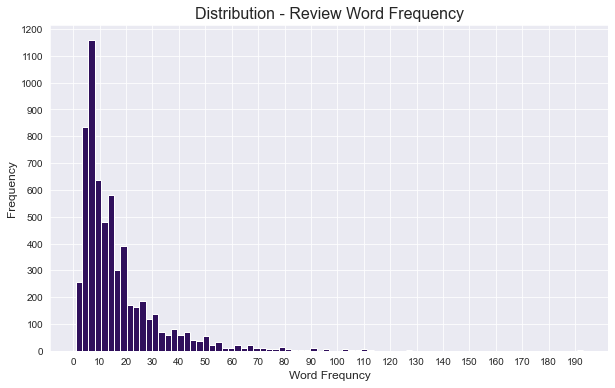

In [24]:
plot_word_counts(word_freq)

In [25]:
# Using a word cloud find the top 500 words by frequency among all the articles after processing the text

def plot_word_cloud(text):
    '''
    Function to plot word cloud for given text
    '''
    wordcloud = WordCloud(background_color='black', width = 500, height = 250, collocations=False, 
                          colormap = 'viridis', contour_color = 'steelblue')
    wordcloud.generate(text)
    plt.figure(figsize = (18, 8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [26]:
def word_count(df):
    '''
    Function to calculate word frequency of each word
    '''
    words = df.str.split().values.tolist()
    words = [w for seq in words for w in seq]    # list of all words from corpus
    # get word frequency of each word
    words_dist = pd.DataFrame(nltk.FreqDist(words).items(), columns = ['word','Word_Count_pos'])
    words_dist = words_dist.set_index('word')
    words_dist = words_dist.fillna(1)
    words_dist = words_dist.sort_values(by='Word_Count_pos', ascending=False)

    return words, words_dist

In [27]:
WORDS, WORDS_DIST = word_count(train_df['cleaned_review'])
WORDS_DIST.shape

(5896, 1)

In [28]:
# top 40 word with freq
WORDS_DIST.head(40).T

word,not,work,use,great,easy,well,good,one,would,water,...,go,tool,purchase,fit,sprinkler,set,nozzle,cushion,camera,hold
Word_Count_pos,2592,2025,1739,1680,1461,1016,989,863,785,777,...,414,400,388,387,379,378,366,361,344,335


In [29]:
# list of top 500 most_freq word 
top_word_index = WORDS_DIST.sort_values(by='Word_Count_pos', ascending=False).head(500).index

# generate text for top 500 word
word_generate_text = ' '.join([w for w in WORDS if w in top_word_index.tolist()])

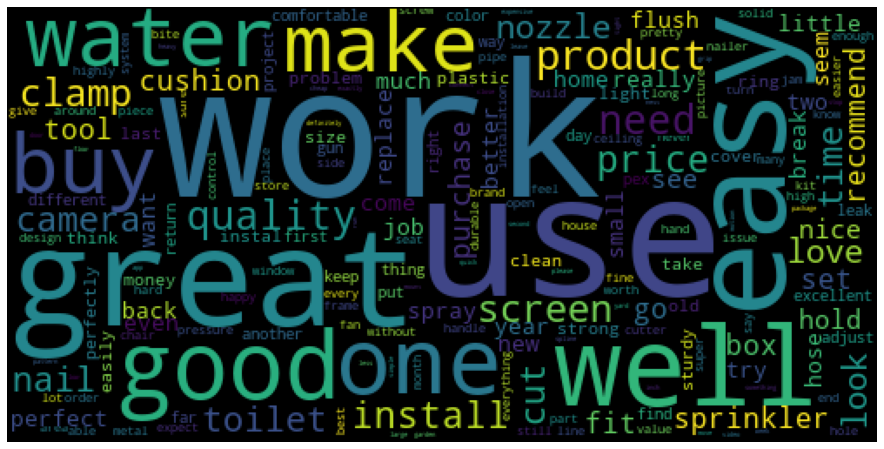

In [30]:
# plot word cloud
plot_word_cloud(word_generate_text)

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [31]:
WORDS = train_df['cleaned_review'].str.split().values.tolist()
WORDS = [w for seq in WORDS for w in seq]    # list of all words from corpus

def find_ngram(word, n):
    word_fd = nltk.FreqDist(word)
    n_gram_fd = nltk.FreqDist(nltk.ngrams(word, n))
    return word_fd, n_gram_fd

In [32]:
# Write your code here to find the top 30 unigram frequency among the reviews
unigram_word_fd, unigram = find_ngram(WORDS, 1)

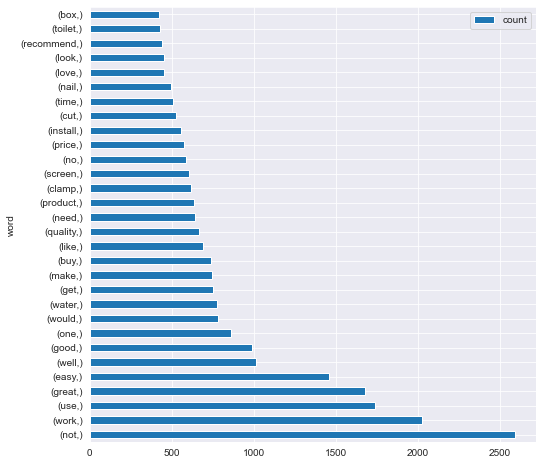

In [33]:
# top 30 unigram frequency
pd.DataFrame(unigram.most_common(30), columns = ['word', 'count']).plot.barh(x = 'word', figsize=(8, 8))
plt.yticks(fontsize=10)
plt.show()

In [34]:
unigram.most_common(10)

[(('not',), 2592),
 (('work',), 2025),
 (('use',), 1739),
 (('great',), 1680),
 (('easy',), 1461),
 (('well',), 1016),
 (('good',), 989),
 (('one',), 863),
 (('would',), 785),
 (('water',), 777)]

In [35]:
# Write your code here to find the top 30 bigram frequency among the reviews
bigram_word_fd, bigram = find_ngram(WORDS, 2)

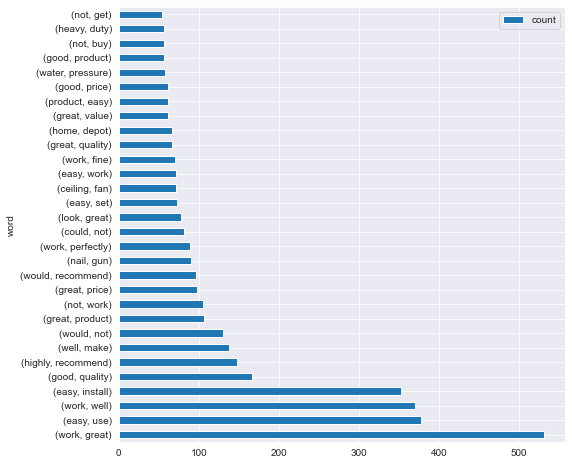

In [36]:
# top 30 bigram frequency
pd.DataFrame(bigram.most_common(30), columns = ['word', 'count']).plot.barh(x = 'word', figsize=(8, 8))
plt.yticks(fontsize=10)
plt.show()

In [37]:
bigram.most_common(10)

[(('work', 'great'), 531),
 (('easy', 'use'), 377),
 (('work', 'well'), 370),
 (('easy', 'install'), 353),
 (('good', 'quality'), 166),
 (('highly', 'recommend'), 147),
 (('well', 'make'), 137),
 (('would', 'not'), 130),
 (('great', 'product'), 107),
 (('not', 'work'), 105)]

In [38]:
# Write your code here to find the top 30 trigram frequency among the reviews
trigram_word_fd, trigram = find_ngram(WORDS, 3)

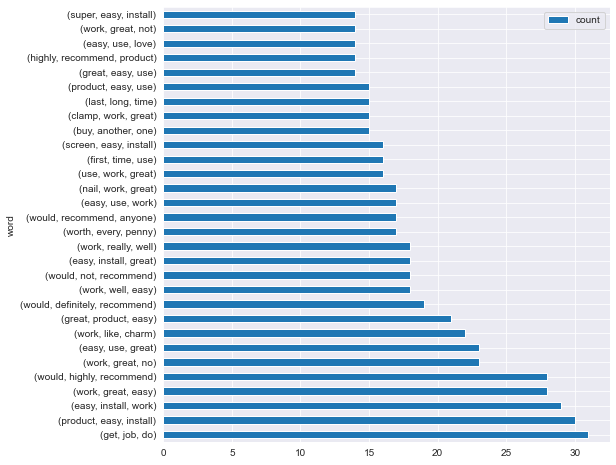

In [39]:
# top 30 trigram frequency
pd.DataFrame(trigram.most_common(30), columns = ['word', 'count']).plot.barh(x = 'word', figsize=(8, 8))
plt.yticks(fontsize=10)
plt.show()

In [40]:
trigram.most_common(10)

[(('get', 'job', 'do'), 31),
 (('product', 'easy', 'install'), 30),
 (('easy', 'install', 'work'), 29),
 (('work', 'great', 'easy'), 28),
 (('would', 'highly', 'recommend'), 28),
 (('work', 'great', 'no'), 23),
 (('easy', 'use', 'great'), 23),
 (('work', 'like', 'charm'), 22),
 (('great', 'product', 'easy'), 21),
 (('would', 'definitely', 'recommend'), 19)]

## 4.Split dataset

In [41]:
X = train_df['cleaned_review'].values
y = train_df['Polarity'].values
y = train_df[['Components', 'Delivery and Customer Support', 'Design and Aesthetics', 'Dimensions', 'Features',
          'Functionality','Installation', 'Material', 'Price', 'Quality', 'Usability', 'Polarity']]
# y = train_df[['Price', 'Quality', 'Usability', 'Polarity']]

In [42]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
X_test = test_df['cleaned_review'].values

In [44]:
print("Train size:", X_train.shape, y_train.shape)
print("Val size:", X_val.shape, y_val.shape)
print("Test size:", X_test.shape)

Train size: (4908,) (4908, 12)
Val size: (1228,) (1228, 12)
Test size: (2631,)


## 5. Vectorization

In [78]:
# bow_vectorizer = CountVectorizer(ngram_range=(1,2), min_df=2, max_features=5000, max_df=0.90, stop_words='english')
bow_vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=5, max_features=5000, max_df=0.95, 
                                 stop_words='english')

In [79]:
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_val_bow = bow_vectorizer.transform(X_val)
X_test_bow = bow_vectorizer.transform(X_test)

## 6. Models

In [80]:
def plot_confusion_matrix(y_actual, y_pred):
    '''
    This method plots confusion matrix.
    '''
    classes = ['Negative', 'Positive']
    tick_marks = np.arange(len(classes))

    accuracy = accuracy_score(y_actual, y_pred)

    conf_matrix = confusion_matrix(y_actual, y_pred)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(conf_matrix, cmap=plt.cm.Reds, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center')
    
    plt.tight_layout()
    plt.xticks(tick_marks , classes, rotation=0)
    plt.yticks(tick_marks , classes)
    plt.xlabel('Predictions')
    plt.ylabel('Actuals')
    plt.title('Confusion Matrix', fontsize=12)
    plt.show()
    
def calcualte_sensi_speci(y, y_predicted, y_prob):
    '''
    This calculates the accuracy, recall, precision, f1, auc
    '''
    confusion = confusion_matrix(y, y_predicted)
    TP = confusion[1,1] # true positive 
    TN = confusion[0,0] # true negatives
    FP = confusion[0,1] # false positives
    FN = confusion[1,0] # false negatives
    
#     sensitivity = round(TP / float(TP+FN), 2)
#     specificity = round(TN / float(TN+FP), 2)

    accuracy = round((TP+TN)/(TP+TN+FP+FN), 2)
    recall = round(TP / float(TP+FN), 2)
    precision = round(TP / float(TP+FP), 2)
    auc = round(roc_auc_score(y, y_prob), 2)
    f1 = round(2 * (precision * recall) / (precision + recall), 2)

    return accuracy, recall, precision, f1, auc

def evaluation (model, xval, yval, plot=False):
    metric = {}
    y_predicted = model.predict(xval)
    y_prob = model.predict_proba(xval)[:, 1]
    
    # metrics
    accuracy, recall, precision, f1, auc = calcualte_sensi_speci(yval, y_predicted, y_prob)
    metric['Accuracy'] = accuracy
    metric['Recall'] = recall
    metric['Precision'] = precision
    metric['F1'] = f1
    metric['AUC'] = auc
    metric['Log_Loss'] = round(log_loss(yval, y_prob), 4)
    
    if plot:
        # plot confusion_matrix
        plot_confusion_matrix(yval, y_predicted)
    
    return metric

def grid_search(model, params, xx_train, yy_train):
    '''
    Function for Grid Search CV.
    '''
    # GridSearchCV
    f_scorer = make_scorer(f1_score, average = 'micro')
    model_lr_final = GridSearchCV(estimator=model, param_grid=params,
                                  cv = 5, scoring=f_scorer, n_jobs = -1, verbose=1)
    # fit cv
    model_lr_final = model_lr_final.fit(xx_train, yy_train)

    # best_estimator
    best_estimator = model_lr_final.best_estimator_
    best_params = model_lr_final.best_params_
    print("Best parameters:", best_params)
    
    return best_estimator, best_params

def one_vs_all(categories, model):
    '''
    Function to fit model on all target columns.
    '''
    all_metric = {}
    for category in categories:
        metric = {}
        #  fit model for each category
        model.fit(X_train_bow, y_train[category])
        #  call function to calculate accuracy, recall, precision, f1, auc 
        metric = evaluation(model, X_val_bow, y_val[category])
        all_metric[category] = metric
    return all_metric

In [81]:
categories = y_train.columns
categories

Index(['Components', 'Delivery and Customer Support', 'Design and Aesthetics',
       'Dimensions', 'Features', 'Functionality', 'Installation', 'Material',
       'Price', 'Quality', 'Usability', 'Polarity'],
      dtype='object')

### 6.1 Logistic Regression

In [82]:
%%time

#  logistic regression object
lr_model = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=123)
params = {'estimator__penalty': ['l1', 'l2'],'estimator__C': [1,3,4,5,6,7,8,9]}

one_rest_model = OneVsRestClassifier(lr_model)

# grid search

lr_model_bow, best_params = grid_search(one_rest_model, params, X_train_bow, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   13.7s finished


Best parameters: {'estimator__C': 5, 'estimator__penalty': 'l2'}
Wall time: 14.1 s


In [83]:
lr_metric = one_vs_all(categories, lr_model_bow)

In [84]:
pd.DataFrame(lr_metric).T

,Accuracy,Recall,Precision,F1,AUC,Log_Loss
Components,0.93,0.53,0.37,0.44,0.89,0.1922
Delivery and Customer Support,0.98,0.68,0.66,0.67,0.95,0.0822
Design and Aesthetics,0.93,0.72,0.67,0.69,0.93,0.2070
Dimensions,0.93,0.75,0.70,0.72,0.93,0.2112
Features,0.93,0.61,0.40,0.48,0.90,0.1898
Functionality,0.85,0.80,0.84,0.82,0.93,0.3448
Installation,0.96,0.86,0.84,0.85,0.98,0.1266
Material,0.98,0.68,0.58,0.63,0.95,0.0773
Price,0.96,0.89,0.85,0.87,0.99,0.1267
Quality,0.87,0.79,0.82,0.80,0.92,0.3352


### 6.2 NB

In [52]:
%%time

nv_model = MultinomialNB()
params = {'estimator__alpha': (0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 0.8, 1, 5, 10)}

one_rest_model = OneVsRestClassifier(nv_model)

# grid search
nb_model_bow, best_params = grid_search(one_rest_model, params, X_train_bow, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best parameters: {'estimator__alpha': 0.2}
Wall time: 1.27 s


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished


In [53]:
nb_metric = one_vs_all(categories, nb_model_bow)

In [54]:
pd.DataFrame(nb_metric).T

,Accuracy,Recall,Precision,F1,AUC,Log_Loss
Components,0.95,0.00,0.00,NaN,0.86,0.1627
Delivery and Customer Support,0.97,0.11,0.80,0.19,0.94,0.0823
Design and Aesthetics,0.93,0.39,0.91,0.55,0.87,0.2120
Dimensions,0.92,0.37,0.91,0.53,0.90,0.2232
Features,0.95,0.05,0.60,0.09,0.90,0.1490
Functionality,0.82,0.76,0.82,0.79,0.90,0.4110
Installation,0.94,0.59,0.89,0.71,0.95,0.1627
Material,0.98,0.00,NaN,NaN,0.91,0.0795
Price,0.93,0.52,0.98,0.68,0.94,0.1828
Quality,0.82,0.60,0.81,0.69,0.89,0.4049


## Predict on test data

**Use Logistic Regression model for prediction**

In [55]:
def pred_one_vs_all(categories, model):
    all_prob, all_pred = {}, {}
    for category in categories:
        #  fit model for each category
        model.fit(X_train_bow, y_train[category])
        
        #  prediction on test data for each category
        y_predicted = model.predict(X_test_bow)
        y_prob = model.predict_proba(X_test_bow)[:, 1]
        all_prob[category] = y_prob
        all_pred[category] = y_predicted

    return all_prob, all_pred

In [56]:
all_prob, all_pred  = pred_one_vs_all(categories, lr_model_bow)

In [57]:
test_pred = pd.DataFrame(all_prob)
# test_pred = pd.DataFrame(all_pred)

## Submission 

In [58]:
# test_sub = test_df[['Id', 'Review']]

# test_sub.shape, test_pred.shape

In [59]:
# frames = [test_sub, test_pred]
# submission_df = pd.concat(frames, axis=1)

In [60]:
submission_df = test_pred

submission_df.to_csv('my_submission_file.csv', index=False)

In [61]:
submission_df.shape

(2631, 12)

In [62]:
submission_df.head()

,Components,Delivery and Customer Support,Design and Aesthetics,Dimensions,Features,Functionality,Installation,Material,Price,Quality,Usability,Polarity
0,0.953292,0.095851,0.103246,0.155435,0.027795,0.144187,0.013872,0.529594,0.022934,0.678925,0.067814,0.008892
1,0.015654,0.034560,0.014603,0.137465,0.018919,0.940062,0.006819,0.008668,0.053217,0.160118,0.055238,0.948147
2,0.034344,0.003882,0.013076,0.020790,0.007378,0.214027,0.081428,0.003221,0.077825,0.036064,0.999978,0.994966
3,0.059708,0.008984,0.080882,0.030851,0.007267,0.938655,0.058475,0.009077,0.057021,0.469391,0.042213,0.787580
4,0.056385,0.007157,0.024687,0.117568,0.025451,0.965083,0.005895,0.017558,0.025101,0.467424,0.045476,0.730061
